In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append('../CausalModel')

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
from CausalModel.SCM import SCM
from CausalModel.CMD import ODist, IDist
from CausalModel.Mechanisms import LinearAdditive
from pomegranate.distributions import IndependentComponentsDistribution
from pomegranate.distributions import NormalDistribution
from pomegranate.distributions import UniformDistribution
from pomegranate.distributions import MultivariateGaussianDistribution
from cdt.metrics import SID
import networkx as nx
import seaborn as sns; sns.set(context="paper", color_codes=True)
import copy
import numpy as np
from scipy import stats

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


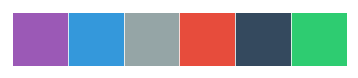

In [6]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
current_palette = sns.color_palette(flatui)
sns.palplot(current_palette)
color_a = current_palette[1]
color_b = current_palette[3]

# Helpers

In [7]:
def get_samples(scm, n_samples):
    samples = scm.sample(n_samples)
    return samples
    
def plot_observational(scm_a, scm_b, n=1000, plt_title="obs", ax=None):
    samples_a = get_samples(scm_a, n)
    samples_a.columns = ['A', 'B']
    samples_b = get_samples(scm_b, n) 
    samples_b.columns = ['A_b', 'B_b']
    
    sns.set(style='white', context='notebook')
    plt.figure(figsize=(9,7))
    
    graph  = sns.jointplot(x='A', y='B', data=samples_a, label="+", color=sns.color_palette()[0], s=8)
    
    graph.x = samples_b.A_b
    graph.y = samples_b.B_b
    graph.plot_joint(plt.scatter, marker='o', color=sns.color_palette()[1], label='-', s=8)
    
    patch_1 = mpatches.Patch(color=sns.color_palette()[0], label='$A \\nearrow B$')
    patch_2 = mpatches.Patch(color=sns.color_palette()[1], label='$A \\searrow B$')
    
    ax.legend(handles=[patch_1, patch_2])
#    plt.savefig(plt_name, format="pdf")
    
#   sns.jointplot(x='0_b', y='1_b', data=samples_b, label="-")

def plot_interventional(scm_a, scm_b, n=10000, plt_name="int"):
    scm_a.intervene(0, 2)
    samples_a = scm_a.sample(n)
    samples_a.columns = ['A', 'B']

    
    scm_b.intervene(0, 2)
    samples_b = scm_b.sample(n)
    samples_b.columns = ['A', 'B']
    
    sns.set_context("notebook")

    plt.figure(figsize=(9,7))
    
    ax = sns.kdeplot(samples_a['B'], shade=True, label='$P^{A \\nearrow B; do(A=3)}_{B}$')    
    sns.kdeplot(samples_b['B'], shade=True, label='$P^{A \\searrow B; do(A=3)}_{B}$', ax=ax)
    
    plt.xlabel('B', fontsize=17)
    plt.ylabel('Density p(B)', fontsize=17)
    
    ax.legend(fontsize='x-large')
#    plt.savefig(plt_name, format="pdf")

In [26]:
def intervene(scm, node, value):
    new_scm = copy.deepcopy(scm)
    new_scm.intervene(node, value)
    return new_scm
    
def plot_observation_vs_interventional(scm_a, scm_b, nb_samples=1000, fname=None):
    samples_a = scm_a.sample(nb_samples)
    samples_b = scm_b.sample(nb_samples)
    
    intervened_scm_a = intervene(scm_a, node=0, value=3)
    intervened_scm_b = intervene(scm_b, node=0, value=3)
    
    interv_samples_a = intervened_scm_a.sample(nb_samples)
    interv_samples_b = intervened_scm_b.sample(nb_samples)
    
    sns.set(style='white', context='notebook')
    fig, axes = plt.subplots(1,2, figsize=(10,5))

    
    ValsCount = samples_b.shape[0]
    ColorsRepeated_1 = np.repeat(np.atleast_2d(color_a), ValsCount, axis = 0)
    ColorsRepeated_2 = np.repeat(np.atleast_2d(color_b), ValsCount, axis = 0)
    
    samples_a.plot.scatter(x=samples_a.columns[0], y=samples_a.columns[1], 
                           c=ColorsRepeated_1, s=8,
                           ax=axes[0])
    samples_b.plot.scatter(x=samples_b.columns[0], y=samples_b.columns[1], 
                           c=ColorsRepeated_2, s=8, 
                           ax=axes[0])
    
    axes[0].set_xlabel('A', fontsize=17)
    axes[0].set_ylabel('B', fontsize=17)
    axes[0].set_title('P(A,B)', fontsize=17)
    
    sns.kdeplot(interv_samples_a[interv_samples_a.columns[1]], shade=True, 
                #label='$P^{A \\nearrow B; do(A=2)}_{B}$', 
                color=color_a,
                label='',
                ax=axes[1])    
    sns.kdeplot(interv_samples_b[interv_samples_b.columns[1]], shade=True, 
                #label='$P^{A \\searrow B; do(A=2)}_{B}$', 
                color=color_b,                
                label='',
                ax=axes[1])
    
    axes[1].set_xlabel('B', fontsize=17)
    axes[1].set_ylabel('Density p(B)', fontsize=17)
    axes[1].set_title('P(B | do(A=3))', fontsize=17)
    
    fig.tight_layout(pad=3.0)
    
    patch_1 = mpatches.Patch(color=color_a, label='$A \\nearrow B$')
    patch_2 = mpatches.Patch(color=color_b, label='$A \\searrow B$')
    
    fig.legend(handles=[patch_1, patch_2], loc='upper center', ncol=2, fontsize=
              'large')
    if fname:
        fig.savefig(fname, dpi=300)
    plt.show()

In [9]:
def build_graph():
    G = nx.DiGraph()
    G.add_node(0, observed=True)
    G.add_node(1, observed=True)
    G.add_edge(0,1)
#    nx.draw_networkx(G)
    return G

In [10]:
def build_mechanisms(beta):
    A_mechanism = LinearAdditive(nb_causes=0)
    B_mechanism = LinearAdditive(nb_causes=1, generate_random=False)
    B_mechanism.coeffs = [beta]
    return [A_mechanism, B_mechanism]

In [11]:
def build_noises(mu_a, sigma_a, mu_b, sigma_b):
    return IndependentComponentsDistribution([
        NormalDistribution(mu_a, sigma_a),
        NormalDistribution(mu_b, sigma_b)
    ])

In [12]:
def build_SCM(beta, mu_a, sigma_a, mu_b, sigma_b):
    G = build_graph()
    mechanisms = build_mechanisms(beta)
    noises = build_noises(mu_a, sigma_a, mu_b, sigma_b)
    return SCM(G, mechanisms, noises)

In [13]:
def display_causal_graphs(scm_a, scm_b, label_a, label_b):
    fig, axes = plt.subplots(1,2, figsize=(5,5))
    
    node_color_a = [color_a, color_a]
    node_color_b = [color_b, color_b]
    
    nx.draw_networkx(scm_a.causal_graph, node_size=(1000,1000),
                     pos={0: [0,1], 1: [1,0]},
                     node_color=node_color_a,
                     labels = {0:'A', 1: 'B'},
                     ax=axes[0])
    axes[0].set_title(label_a, fontsize=15)
    nx.draw_networkx(scm_b.causal_graph, node_size=(1000,1000),
                     pos={0: [0,1], 1: [1,0]},
                     node_color=node_color_b,                                          
                     labels = {0:'A', 1: 'B'},      
                     ax=axes[1])
    axes[1].set_title(label_b, fontsize=15)
    plt.show()

# Case Study

### Case $\sigma_a = \sigma_b$

For both: A follow normal with mu: 0 and sigma: 1


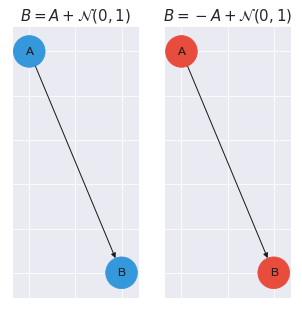

In [14]:
scm_1 = build_SCM(1, 0, 1, 0, 1)
scm_2 = build_SCM(-1, 0, 1, 0, 1)
print("For both: A follow normal with mu: {} and sigma: {}".format(0, 1))
display_causal_graphs(scm_1, scm_2, '$B = A + \mathcal{N}(0,1)$', '$B = -A + \mathcal{N}(0,1)$')

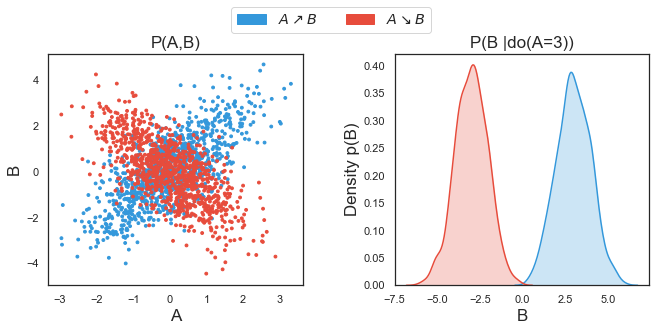

In [28]:
plot_observation_vs_interventional(scm_1, scm_2, 1000, fname='results/case_study_1.pdf')

In [20]:
print("OD(A, B): %.2f" % ODist(scm_1, scm_2, 1000, discrete=False))
print("SID(A, B): %.2f" % SID(scm_1.causal_graph, scm_2.causal_graph))
print("ID(A, B): %.2f" % IDist(scm_1, scm_2, 1000, discrete=False))

OD(A, B): 0.05
SID(A, B): 0.00
ID(A, B): 1.21


### Case : $\sigma_a << \sigma_b$

For both: A follow normal with mu: 0 and sigma: 0.1


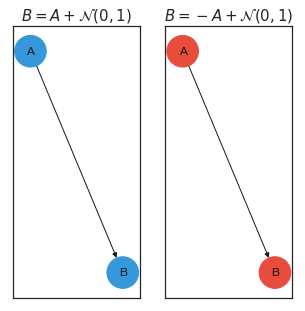

In [17]:
scm_a = build_SCM(1, 0, 0.1, 0, 1)
scm_b = build_SCM(-1, 0, 0.1, 0, 1)
print("For both: A follow normal with mu: {} and sigma: {}".format(0, 0.1))
display_causal_graphs(scm_1, scm_2, '$B = A + \mathcal{N}(0,1)$', '$B = -A + \mathcal{N}(0,1)$')

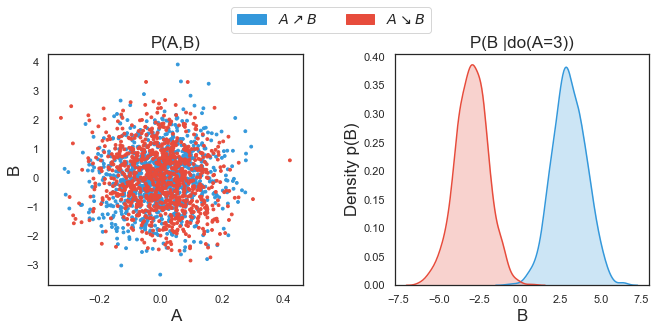

In [35]:
plot_observation_vs_interventional(scm_a, scm_b, 1000, fname='results/case_study_2.pdf')

In [21]:
print("OD(A, B): %.2f" % ODist(scm_a, scm_b, 1000, discrete=False))
print("SID(A, B): %.2f" % SID(scm_a.causal_graph, scm_b.causal_graph))
print("ID(A, B): %.2f" % IDist(scm_a, scm_b, 1000, discrete=False))

OD(A, B): 0.03
SID(A, B): 0.00
ID(A, B): 1.40
